In [2]:
import numpy as np
import pandas as pd
import os

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

from alibi_detect.od import SpectralResidual

import seaborn as sns
sns.set(rc={'figure.figsize':(16,8)})

In [3]:
data_path = '../../../../data/train_data/host'
dfs = {}
for file in os.listdir(data_path):
    print('Reading ' + file)
    dfs[file[:-4]] = pd.read_csv(data_path+'/'+file) 

Reading dcos_docker.csv
Reading os_linux.csv
Reading db_oracle_11g.csv
Reading mw_redis.csv
Reading dcos_container.csv


In [4]:
def gen_train_seq(values):
    time_steps = 10

    output = []
    for i in range(len(values) - time_steps):
        output.append(values[i : (i + time_steps)])
    
    return np.stack(output)

In [5]:
for key in dfs:
    print('*'*40)
    print(key)
    df = dfs[key]
    for name in list(df.name.unique()):
        df_n = df[df.name==name]
        for cmdb_id in list(df_n.cmdb_id.unique()):
            df_nc = df_n[df_n.cmdb_id == cmdb_id]
            df_nc = df_nc.set_index('timestamp')['value']
        if np.mean(df_nc) != 0:
            df_sample = df_nc
            break

****************************************
dcos_docker
****************************************
os_linux
****************************************
db_oracle_11g
****************************************
mw_redis
****************************************
dcos_container


In [6]:
print(dfs['dcos_docker']['cmdb_id'].unique())
print(dfs['dcos_docker']['name'].unique())

['docker_008' 'docker_003' 'docker_002' 'docker_005' 'docker_004'
 'docker_007' 'docker_001' 'docker_006']
['container_session_used' 'container_fgct' 'container_cpu_used'
 'container_thread_idle' 'container_thread_running'
 'container_thread_total' 'container_fgc' 'container_thread_used_pct'
 'container_mem_used']


<ipython-input-13-ddc9beef50ec>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']
No threshold level set. Need to infer threshold using `infer_threshold`.


1.249014164685438


<AxesSubplot:ylabel='value'>

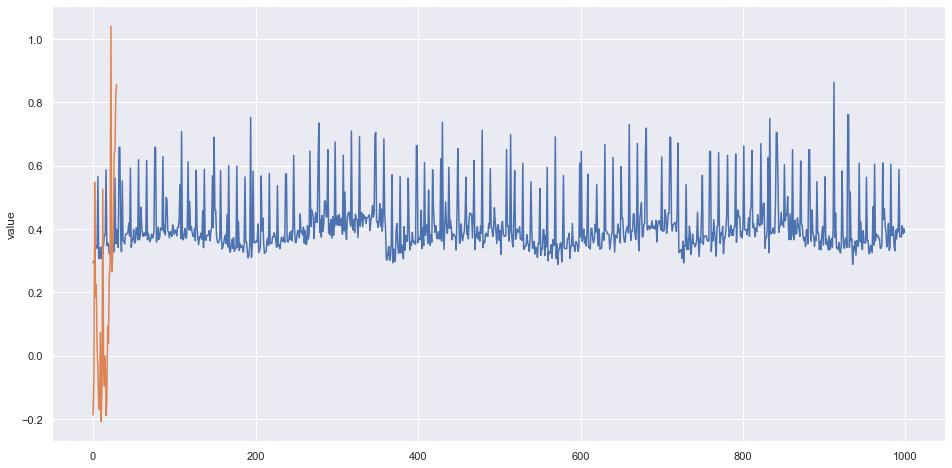

In [13]:
df = dfs['os_linux']
df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']

# df = dfs['dcos_docker']
# df = df[df.name == 'container_cpu_used'][df.cmdb_id=='docker_003']
def get_past(df, curr_time, window_size):
    step_size = 1000*60
    df_new = pd.DataFrame(columns=['timestamp', 'value'])

    for time in [curr_time - step_size*x for x in range(window_size)][::-1]:
        if len(df[df.timestamp == time]) == 0:
            plug_time = np.max(df[df.timestamp < time]['timestamp'])
            row = {}
            row['timestamp'] = time
            row['value'] = df.loc[df.timestamp==plug_time, 'value'].values[0]
            df_new = df_new.append(row, ignore_index=True)
        else:
            row = {}
            row['timestamp'] = time
            print(df.loc[df.timestamp==time, 'value'].values[0])
            row['value'] = df.loc[df.timestamp==time, 'value'].values[0]
            df_new = df_new.append(row, ignore_index=True)
    
    return df_new

df = get_past(df, np.max(df.timestamp.unique()), len(df))

od = SpectralResidual(
    window_amp=30,
    window_local=30,
    n_est_points=5,
    n_grad_points=5
)

od.infer_threshold(df['value'].values, threshold_perc=99.9)
print(od.threshold)

window_size = 1000
inst_s = od.predict(df['value'].values[:window_size],return_instance_score=True)['data']['instance_score']
sns.lineplot(x=range(len(df[:window_size].values)), y='value',data=df[:window_size])
sns.lineplot(x=range(len(inst_s[-30:])), y=inst_s[-30:])

In [16]:
    print( od.predict(df['value'].values[:window_size])['data']['is_outlier'][-1])

{'data': {'instance_score': array([ 6.53679279e-01,  5.09057603e-01,  3.83271947e-01,  5.78411194e-01,
        4.85190802e-01,  3.99414445e-01,  1.42947273e+00,  1.87761030e-01,
        1.64056607e-01,  1.60338590e-01, -8.18464646e-03,  1.79537919e-01,
       -2.21522549e-02,  4.02268293e-02,  1.37016406e-01,  1.26743877e-01,
        7.27532529e-01, -8.19111725e-02, -1.89786879e-02, -7.92808474e-02,
       -1.93762283e-01, -2.31544107e-01, -3.05891056e-01, -1.55762534e-01,
       -5.71569457e-02, -1.34635773e-01, -3.27252626e-01,  5.85631216e-01,
       -1.40155344e-01, -2.28545521e-02, -1.29803797e-01, -1.76294347e-01,
        8.45315505e-01,  8.04273158e-01, -2.59913915e-02, -1.85918776e-01,
        3.94344102e-01, -1.09189669e-01, -1.47347502e-01, -1.84439133e-01,
       -6.48696867e-02, -1.38342293e-03, -1.51178518e-01, -1.49111111e-01,
       -3.24559776e-03, -5.91845398e-02,  4.61210187e-01, -1.96857236e-01,
       -1.54623643e-01, -1.17099821e-01, -5.58689422e-02, -1.32589985e-0

<ipython-input-8-d39ce934a421>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']


<AxesSubplot:xlabel='timestamp', ylabel='value'>

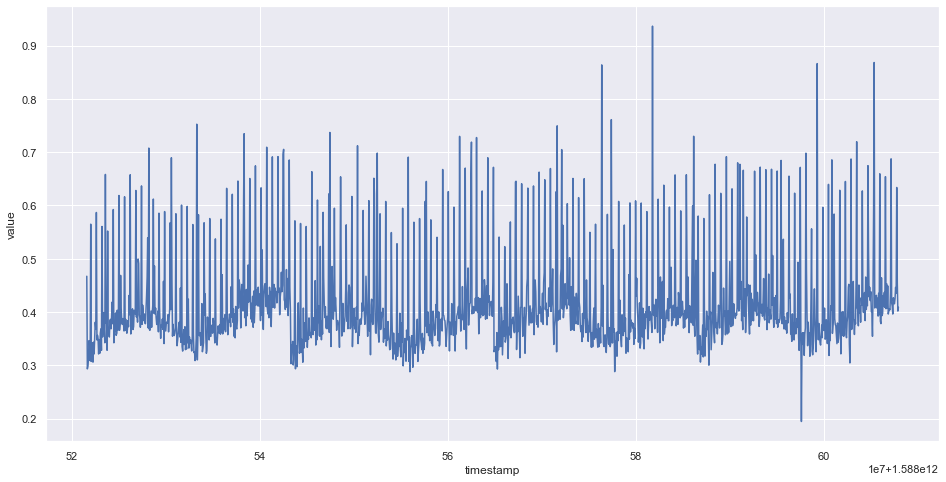

In [8]:
df = dfs['os_linux']
df = df[df.name == 'CPU_user_time'][df.cmdb_id=='os_001']
sns.lineplot(y='value',x='timestamp',data=df)